# 03.01 - Demand Data - Compile & Review

 + Imports & Setup
 + Compile Ontario Raw Demand Data into a Single File
 + Data Review
     + Visual Inspection
     + Verify Data Integrity
         + Data Gaps
         + Outlier Investigation
             + Northeast Blackout of 2003
             + 911 2001 Terrorist Attacks
         + Check Peak Data against Alternate Source

## Imports & setup

In [1]:
import pathlib
import datetime
from os import PathLike
from typing import Union

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


%matplotlib inline

PROJECT_DIR = pathlib.Path.cwd().parent.resolve()
RAW_DATA_DIR = PROJECT_DIR / 'data' / '01-raw' /'demand'
COMPILED_DATA_DIR = PROJECT_DIR / 'data' / '02-compiled' / 'demand'

## Compile Ontario Raw Demand Data into Single File

In [2]:
def format_demand_file(filepath: Union[str, PathLike]) -> pd.DataFrame:
    """
    Read an IESO .csv demand file to a Pandas DataFrame
    Accepts pre 2002 format and post 2001 format
    Clean up - shorten col names, merge date and time to datetime, set datetime index
    Returns ascending date sorted DataFrame
    """
    keeper_cols = ['datetime', 'ont_demand']
    if '1994-2002' in str(filepath):
        col_renames = {'DateTime': 'datetime', 'OntarioDemand': 'ont_demand'}
        header = 0
    else:
        col_renames = {'Date': 'date', 'Hour': 'time', 'Ontario Demand': 'ont_demand'}
        header = 3
        
    df = pd.read_csv(filepath, header=header, parse_dates=True, dtype={'Hour': int}, infer_datetime_format=True)
    df.rename(columns=col_renames, inplace=True)

    if 'datetime' not in df.columns:
        df['time'] = df['time'] - 1
        df['datetime'] = pd.to_datetime(df['date']) + df['time'].astype('timedelta64[h]')
    else:
        df['datetime'] = pd.to_datetime(df['datetime'])

    df = df[keeper_cols]
    df.set_index('datetime', inplace=True, drop=True)
    df.sort_index(inplace=True)
    
    return df


In [3]:
# Get the raw directory filepaths
csv_fps = [fp for fp in RAW_DATA_DIR.iterdir() if fp.is_file()]
# create multiple dfs from each filepath
dfs = [format_demand_file(fp) for fp in csv_fps]
# combine into a single DataFrame and save in the interim dir
df = pd.concat(dfs, axis=0)
df.sort_index(inplace=True)
df.to_csv(COMPILED_DATA_DIR / "demand.csv")

## Data Review

In [4]:
df = pd.read_csv(COMPILED_DATA_DIR / 'demand.csv', index_col=0, parse_dates=True)
df.head()

,ont_demand
datetime,
1994-01-01 00:00:00,14422
1994-01-01 01:00:00,13845
1994-01-01 02:00:00,13372
1994-01-01 03:00:00,13025
1994-01-01 04:00:00,12869


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 222096 entries, 1994-01-01 00:00:00 to 2019-06-03 23:00:00
Data columns (total 1 columns):
ont_demand    222096 non-null int64
dtypes: int64(1)
memory usage: 3.4 MB


### Visual Inspection

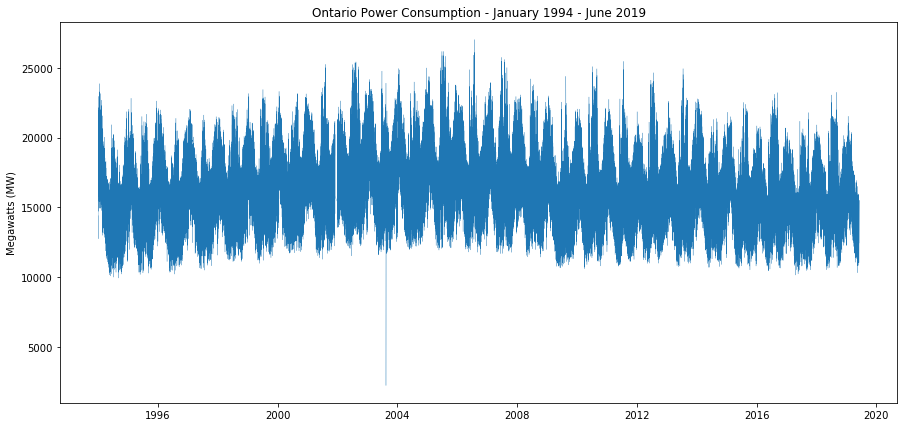

In [6]:
#plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(df, linewidth=0.25)
ax.set_ylabel('Megawatts (MW)')
ax.set_title('Ontario Power Consumption - January 1994 - June 2019')
plt.show();

####  Look Closer at 2000 to 2003

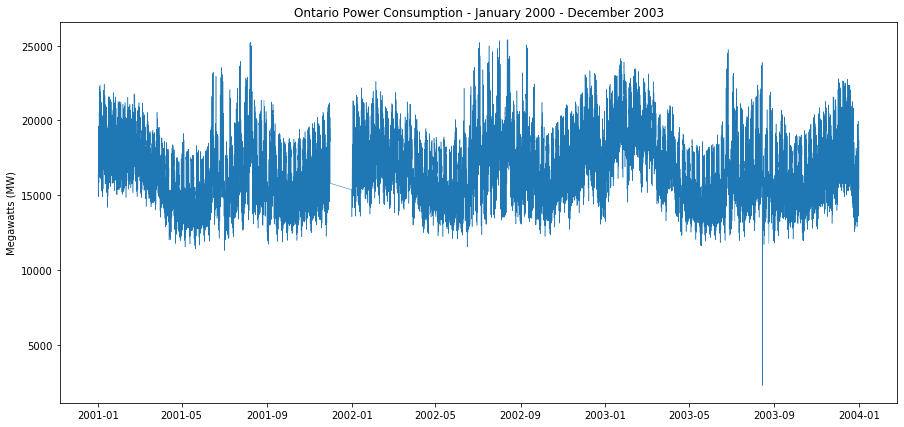

In [7]:
#plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(df.loc['2001-01-01' : '2003-12-31', 'ont_demand'], linewidth=0.5)
ax.set_ylabel('Megawatts (MW)')
ax.set_title('Ontario Power Consumption - January 2000 - December 2003')
plt.show();

### Verify Data integrity, and Identify Problems

The data should cover every hour from midnight on 31 December 1993, to 11:00 PM on 3 June 2019

There should be no gaps, or major dips in the demand data, apart from province wide power outages

#### Data Gaps

In [8]:
# create an empty DataFrame that starts at the data start date and ends at the data end date
start = df.index.values[0] ; end = df.index.values[-1] ; freq = '1h'
full_index = pd.DatetimeIndex(freq=freq, start=start, end=end)
mt_df = pd.DataFrame([np.NaN]* len(full_index), index=full_index)
# Concat this fully indexed mt dataFrame to the data dataFrame with outer join
concat_df = pd.concat([mt_df, df ], axis=1,join='outer')
# find any places where the power data is a NaN
concat_df[concat_df['ont_demand'].isnull()].index

/home/david/anaconda3/envs/ana_py37tf/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  app.launch_new_instance()


DatetimeIndex(['2001-12-01 00:00:00', '2001-12-01 01:00:00',
               '2001-12-01 02:00:00', '2001-12-01 03:00:00',
               '2001-12-01 04:00:00', '2001-12-01 05:00:00',
               '2001-12-01 06:00:00', '2001-12-01 07:00:00',
               '2001-12-01 08:00:00', '2001-12-01 09:00:00',
               ...
               '2001-12-31 14:00:00', '2001-12-31 15:00:00',
               '2001-12-31 16:00:00', '2001-12-31 17:00:00',
               '2001-12-31 18:00:00', '2001-12-31 19:00:00',
               '2001-12-31 20:00:00', '2001-12-31 21:00:00',
               '2001-12-31 22:00:00', '2001-12-31 23:00:00'],
              dtype='datetime64[ns]', length=744, freq='H')

In [9]:
df = concat_df.copy(deep=True)
df.drop(columns=0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 222840 entries, 1994-01-01 00:00:00 to 2019-06-03 23:00:00
Freq: H
Data columns (total 1 columns):
ont_demand    222096 non-null float64
dtypes: float64(1)
memory usage: 3.4 MB


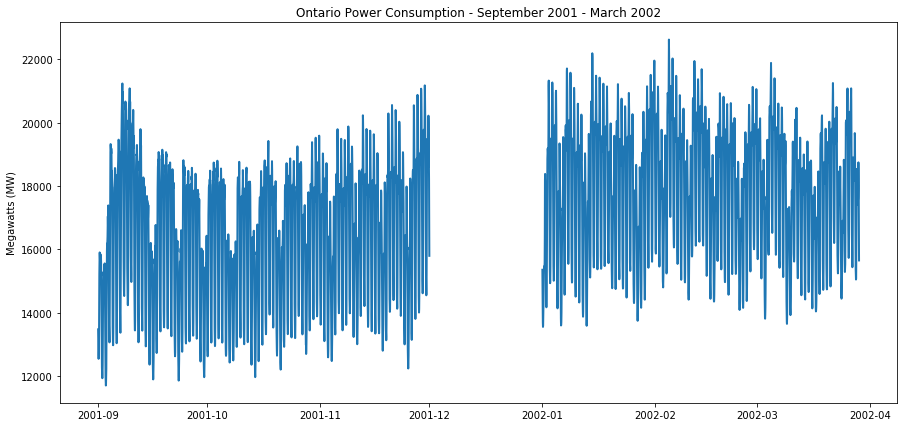

In [10]:
#plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(df.loc['2001-09-01':'2002-03-28'], linewidth=2.0)
ax.set_ylabel('Megawatts (MW)')
ax.set_title('Ontario Power Consumption - September 2001 - March 2002')
plt.show();

This gap will require imputation

#### Outliers Investigation

##### - Northeast Blackout of 2003

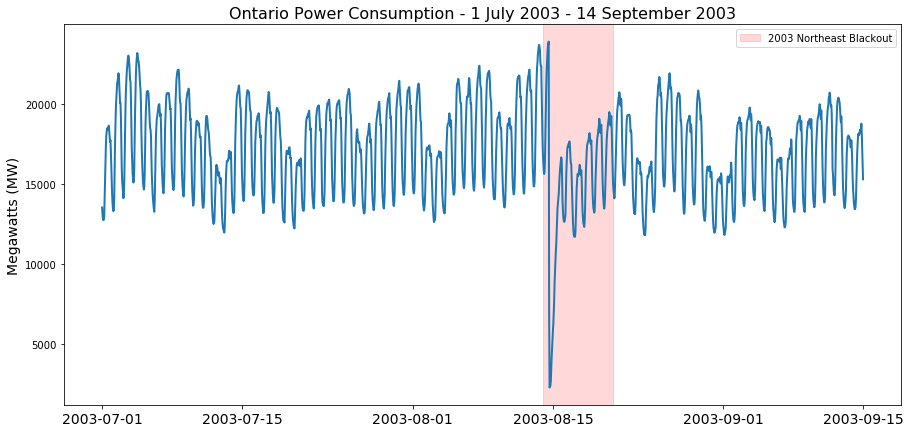

In [11]:
#plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(df.loc['2003-07-01':'2003-09-14'], linewidth=2)
ax.axvspan('2003-08-14', '2003-08-21', alpha=0.15, color='red', label='2003 Northeast Blackout')
ax.set_ylabel('Megawatts (MW)', fontsize=14)
ax.set_title('Ontario Power Consumption - 1 July 2003 - 14 September 2003', fontsize=16)
plt.legend()
plt.xticks(fontsize=14)
plt.savefig(PROJECT_DIR / 'notebooks' / 'saved-images' / '2003-blackout.PNG', bb_inches='tight')
plt.show();

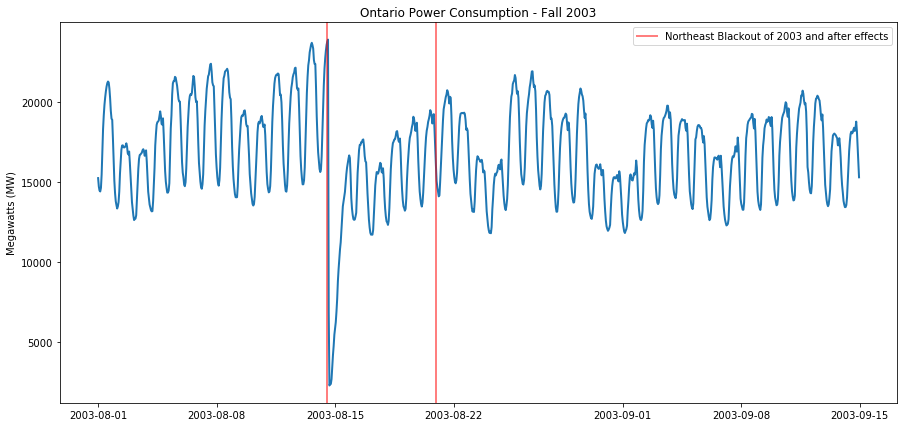

In [12]:
lw=2
#plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(df.loc['2003-08-01':'2003-09-14'], linewidth=lw)
ax.axvline('2003-08-14 12:00:00', color='r', alpha=0.5,
           label='Northeast Blackout of 2003 and after effects',
          linewidth=lw)
ax.axvline('2003-08-20 23:00:00', color='r', alpha=0.5, linewidth=lw)
ax.set_ylabel('Megawatts (MW)')
ax.set_title('Ontario Power Consumption - Fall 2003')
plt.legend()
#plt.savefig(PROJECT_DIR / 'notebooks' / 'saved-images' / '2003-blackout.PNG')
plt.show();

The dramatic drop in demand starting on August 14 2003 was the [Northeast Blackout of 2003](https://en.wikipedia.org/wiki/Northeast_blackout_of_2003). 55 million people in the US and Canada lost electrical power during this incident. At the time, this was the second largest blackout in history

I suffered through this and when, after a couple of days, the electricity supply came back up in the Greater Toronto Area, the public were requested to limit their electricity usage by not running air conditioning. This request was common across each region as power was restored. The gradual nature of power restoration across regions, and the artificially lowered demand explain the lowered demand in the 6 days following August 14. 

In summary, the data within the period from midday on 14 August to midday on 20 August is lower as the result of an extra-ordinary event - It is an outlier.

For these 6 days, the actual data will be discarded, and replaced with imputed data. This will reflect more typical demand.

##### - 911 Terrorist Attacks of 2001

A unique event this century, was the 911 terrorist attack. All civil flights in the US & Canada were stopped until September 13. I suspected this would have had a severe impact on power usage. However, the although the day of Septemeber 11 shows a slightly lower daily peak, it does not appear to be significant enough to warrant an intervention.

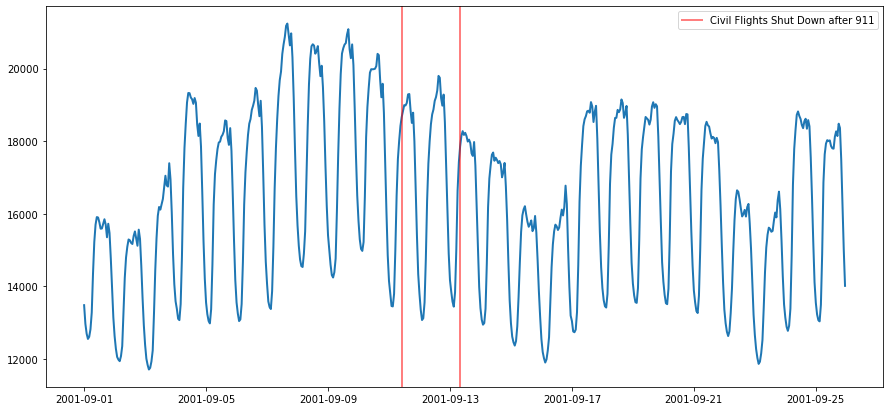

In [13]:
lw=2
#plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(df.loc['2001-09-01':'2001-9-25'], linewidth=lw)
ax.axvline('2001-09-11 10:00:00', color='r', alpha=0.5,
           label = 'Civil Flights Shut Down after 911',
          linewidth=lw)
ax.axvline('2001-09-13 08:00:00', color='r', alpha=0.5, linewidth=lw)
plt.legend()
plt.show();

#### Check Peak Data against Alternate Source

In [14]:
start = '2017-05-01 00:00:00'
end = '2018-04-30 23:00:00'
df.loc[start:end].resample('D').max().sort_values(by='ont_demand', ascending=False).head(10)

,ont_demand
2017-09-25,21786.0
2017-09-26,21542.0
2017-06-12,21168.0
2018-01-05,20906.0
2018-01-06,20768.0
2017-07-19,20627.0
2017-09-24,20457.0
2018-01-07,20429.0
2018-01-03,20380.0
2017-07-06,20366.0


Extract from the Ontario Independent Electricity System Operator (IESO) webpage data below:

![alt text](images/2018-2019-peak-power-periods-IESO.png)

These peak days exactly match the data published by the Ontario Independent Electricity System Operator (IESO) - the body that matches electricity suopply to demand in Ontario.

In [15]:
df.to_csv(COMPILED_DATA_DIR / "demand.csv")